In [1]:
'''
Importa os módulos usados
'''
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
import math
import random
from collections import Counter
'''
Define um tipo de dado similar ao Pascal "record" or C "struct"
'''
clients = pd.read_csv(r'./clients.csv', header=None, names= ['x', 'y', 'consumo'])

class Struct:
    pass

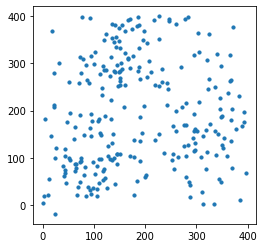

In [2]:
#Cria plot com as posições dos clientes
plt.figure(figsize=(4,4))
plt.scatter(clients['x'], clients['y'], s=10)

## Utilizando a meta-heurística GVNS

In [225]:
def distance(x1, y1, x2, y2) -> float:
    return math.sqrt((x2 - x1)**2 + (y2-y1)**2)


In [226]:
MULTIPLIER = 5

# Calcula o número de pontos em cada eixo (400 metros divididos por 5 metros por ponto)
num_points_x = int(400 / MULTIPLIER)
num_points_y = int(400 / MULTIPLIER)

# Crie um DataFrame vazio com as colunas necessárias
pas = pd.DataFrame(columns=['id', 'x', 'y', 'band', 'isActive'])
possible_coord = pd.DataFrame(columns=['x', 'y'])
coord_list = []

# Crie as coordenadas e adicione ao DataFrame
for i in range(1, num_points_x + 1):
    for u in range(1, num_points_y + 1):
        x_coord = MULTIPLIER * i
        y_coord = MULTIPLIER * u
        point_id = len(possible_coord) + 1  # ID do ponto
        coord_list.append(pd.DataFrame({
            'x': [x_coord],
            'y': [y_coord]
        }))

# Concatene a lista de DataFrames em um único DataFrame
possible_coord = pd.concat(coord_list, ignore_index=True)

In [324]:
pas_coords = []
for i in range(0,25):
    coord = random.randrange(1, 6400) - 1
    pas_coords.append(pd.DataFrame({
        'id': i,
        'x': [possible_coord['x'][coord]],
        'y': [possible_coord['y'][coord]],
        'isActive' : False,
        'band': 0
    }))

pas = pd.concat(pas_coords, ignore_index=True)

In [325]:
def filter_access_point(row: any, x: float, y: float, consumo: float, total_pa: int) -> None:
 
    if (row['band'] + consumo > 54 and (row['isActive'] == False and total_pa >= 25)):
        return math.inf
    
    return distance(float(row['x']), float(row['y']), float(x), float(y))

def nearest_avaliable_access_point(x: float, y: float, consumo: float)-> int:
    total_pa = len(pas[pas['isActive'] == True]['isActive'].tolist())
    pas['distance'] = pas.apply(lambda row: filter_access_point(row, x, y, consumo, total_pa), axis=1)
    nearest_access = pas.loc[pas['distance'].idxmin()]
    if nearest_access['distance'] < 70:
        pas.at[nearest_access['id'], 'band'] += consumo
        if nearest_access['isActive'] == False:
            pas.at[nearest_access['id'], 'isActive'] = True
            total_pa += 1
        return nearest_access['id']
    
    return -1

def init_solution() -> None:
    for index, row in clients.iterrows():
        nearest_access_point_id = nearest_avaliable_access_point(
            row['x'],
            row['y'],
            row['consumo'])
        clients.at[index, 'access_point'] = nearest_access_point_id

init_solution()
percent = len(clients[clients['access_point'] == -1]['access_point'].tolist()) * (100/256)
percent_pa = len(pas[pas['isActive'] == False]['isActive'].tolist()) * (100/25)

print(f'Percentual de usuários conectados: {100 - percent}%')
print(f'Percentual de PAs ativos: {100 - percent_pa}%')



Percentual de usuários conectados: 86.71875%
Percentual de PAs ativos: 96.0%


## Plota

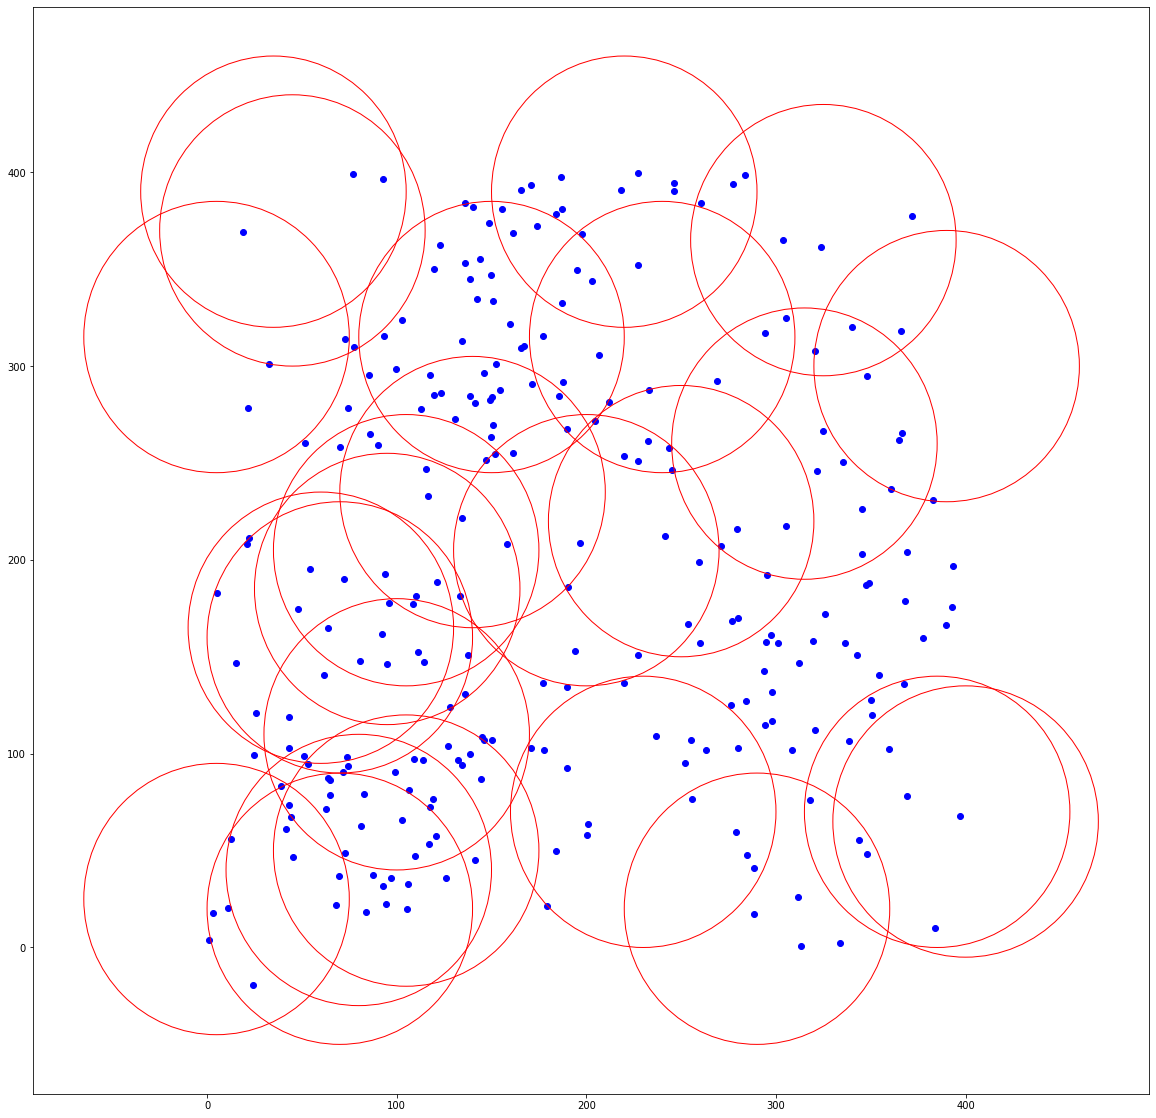

In [301]:
fig, ax = plt.subplots(figsize=(20,20))

ax.scatter(clients['x'], clients['y'], label='Users', color='blue', marker='o')

for index, row in pas.iterrows():
    ax.add_patch(plt.Circle((row['x'], row['y']), 70, fill=False, color="r"))

fig.savefig('plotcircles.png')

plt.show()

## Estruturas de vizinhança


Para este caso, será empregado 3 tipos de Estruturas de vizinhança:
    Shift -> Trocar a posição de 3 PA's que estiverem conectados ao menor número de clientes
    Shift Posicional -> Trocar a Posição de PA's que estiverem muito próximos de outros PA's
    Delete -> Remover PA's com menor uso de banda

In [ ]:
import time 

temp_clients = clients
temp_pas = pas
use_rate_pa = []
def shake(x):
    position = random.randrange(0, 256)
    possible_coord_change = random.randrange(1600)
    x['x'][position] = possible_coord['x'][possible_coord_change]
    x['y'][position] = possible_coord['y'][possible_coord_change]
    x = rearrange_clients(x, clients)
    return x

def encontre_pontos_mais_proximos(x: pd.DataFrame):

    pontos_mais_proximos = None
    menor_distancia = float('inf')

    for index, row in x.iterrows():
        for j in range(index + 1, len(x)):
            ponto1 = (row['x'], row['y'])
            ponto2 = (x['x'][j], x['y'][j])
            distancia = np.linalg.norm(np.array(ponto1) - np.array(ponto2))

            if distancia < menor_distancia:
                menor_distancia = distancia
                pontos_mais_proximos = (row['id'], j)

    return pontos_mais_proximos[0], pontos_mais_proximos[1]

def VND(x):
    count = 0
    k_max = 2
    print(f'Quarto {x}')

    start_time = time.time() 

    while time.time() - start_time < 60:
        k = 1
        x0 = x.copy()
        while k <= k_max:
            print(f'VND: {k}')
            x1 = change_neighborhood(x0, k)
            if is_better_solution(x, x1):
                x = x1
            else:
                k += 1
    
    return x

def rearrange_clients(x: pd.DataFrame, clients: pd.DataFrame):
    for index, row in x.iterrows():
        x['band'][index] = 0
        x['isActive'][index] = False
    
    total_pas = 0
     
    x = x.sort_values('band', ascending=False)
    for index, row in clients.iterrows():
        for indexx, rowx in x.iterrows():
            if distance(rowx['x'], rowx['y'], row['x'], row['y']) <= 70 \
                        and (row['consumo'] + rowx['band'] <= 54):
                x['band'][indexx] += row['consumo']
                x['isActive'][indexx] = True
                total_pas += 1
                clients.at[index, 'access_point'] = rowx['id']
                break
        
    return x            


def change_neighborhood(x: pd.DataFrame, k: int):
    if k == 1:
        access_points_least_used = temp_clients['access_point'].tolist()
        least_common = int((Counter(access_points_least_used).most_common()[-1])[0])
        coord = random.randrange(1, 6400) - 1
        x['x'][least_common] = possible_coord['x'][coord]
        x['y'][least_common] = possible_coord['y'][coord]
        x = rearrange_clients(x, clients)
    if k == 2:
        coord = random.randrange(1, 6400) - 1
        a, b = encontre_pontos_mais_proximos(x)
        x['x'][a] = possible_coord['x'][coord]
        x['y'][a] = possible_coord['y'][coord]
        x['x'][b] = possible_coord['x'][coord]
        x['y'][b] = possible_coord['y'][coord]
        x = rearrange_clients(x, clients)
    
    return x 

def is_better_solution(x: pd.DataFrame, x1: pd.DataFrame, type: int = 0):
    if type == 0:
        print(x)
        pa_use_rate_x =  100 - len(x[x['isActive'] == False]['isActive'].tolist()) * (100/25)
        pa_use_rate_x1 = 100 - len(x1[x1['isActive'] == False]['isActive'].tolist()) * (100/25)
        print(f'Percentual de PAs ativos x:  {pa_use_rate_x}%')
        print(f'Percentual de PAs ativos x1:  {pa_use_rate_x1}%')
        if pa_use_rate_x1 <= pa_use_rate_x:
            use_rate_pa.append(pa_use_rate_x1)
            return True
        else:
            use_rate_pa.append(pa_use_rate_x)
            return False


    return pa_use_rate_x1 < pa_use_rate_x

def GVNS(k_max=2):
    count = 0
    x=pas.copy()
    print(f'Primeiro {x}')
    start_time = time.time() 

    while time.time() - start_time < 60:
        k=1
        x9 = x.copy()
        while k <= k_max:
            print(f'Segundo {x}')

            print(k)
            x1 = shake(x9)  
            print(f'Terceiro {x}')

            x2 = VND(x1)
           
            if is_better_solution(x1, x2):
                x = x2 
                print('Aqui')
            else:
                x = x1
                k += 1

    return x

In [328]:
GVNS()


Primeiro     id    x    y  isActive       band    distance
0    0  325  155      True   8.215737  201.338852
1    1  305  315      True   3.050366  278.307942
2    2  195  235      True   7.413486  151.784951
3    3  205  370      True   1.229107  282.728670
4    4  175  395      True   8.682118  301.258442
5    5  180  225      True   7.349120  136.810968
6    6   90  170      True   6.629608   84.532658
7    7  245  310      True   1.780591  241.183277
8    8   55  170      True   9.601511  106.437566
9    9  250   65      True   3.581266  121.956078
10  10   85  100      True   5.811864   47.368760
11  11  340  345      True   3.745832  323.673907
12  12   10  305      True   5.318915  241.452608
13  13   35   95      True   8.820862   97.276237
14  14  205  310      True  11.101495  225.277954
15  15  100   85      True  23.854282   34.346319
16  16  200  370      True   2.540679  281.483745
17  17   95  215      True   8.410008  123.944265
18  18  285    5      True   4.202936  17

<ipython-input-326-532ef811e10d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][position] = possible_coord['x'][possible_coord_change]
<ipython-input-326-532ef811e10d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][position] = possible_coord['y'][possible_coord_change]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWit

Terceiro     id    x    y  isActive       band    distance
0    0  325  155      True   8.215737  201.338852
1    1  305  315      True   3.050366  278.307942
2    2  195  235      True   7.413486  151.784951
3    3  205  370      True   1.229107  282.728670
4    4  175  395      True   8.682118  301.258442
5    5  180  225      True   7.349120  136.810968
6    6   90  170      True   6.629608   84.532658
7    7  245  310      True   1.780591  241.183277
8    8   55  170      True   9.601511  106.437566
9    9  250   65      True   3.581266  121.956078
10  10   85  100      True   5.811864   47.368760
11  11  340  345      True   3.745832  323.673907
12  12   10  305      True   5.318915  241.452608
13  13   35   95      True   8.820862   97.276237
14  14  205  310      True  11.101495  225.277954
15  15  100   85      True  23.854282   34.346319
16  16  200  370      True   2.540679  281.483745
17  17   95  215      True   8.410008  123.944265
18  18  285    5      True   4.202936  17

<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
13  13   35   95      True  20.917220   97.276237
23  23  210  385      True  12.916775  298.511707
22  22  260  355      True   4.602069  288.080871
21  21  395  190      True   3.898477  278.784410
20  20  285  375     False   0.000000  317.381548
19  19  300  135      True   2.997523  172.037422
18  18  285    5      True   5.040393  178.198639
17  17   95  215      True  21.262211  123.944265
16  16  200  370      True   8.787925  281.483745
15  15  100   85      True  21.059228   34.346319
14  14  205  310      True  12.978441  225.277954
12  12   10  305      True   4.446122  241.452608
1    1  305  315      True   2.900999  278.307942
11  11  340  345      True   0.881850  323.673907
10  10   85  100     False   0.000000   47.368760
9    9  250   65      True   4.133409  121.956078
8    8   55  170      True   3.869614  106.437566
7    7  245  310      True   1.193435  241.183277


<ipython-input-326-532ef811e10d>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][a] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][a] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][b] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:82: SettingWithCopyWarning: 
A value is 

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
13  13   35   95      True  20.917220   97.276237
23  23  210  385      True  12.916775  298.511707
22  22  260  355      True   4.602069  288.080871
21  21  395  190      True   3.898477  278.784410
20  20  285  375     False   0.000000  317.381548
19  19  300  135      True   2.997523  172.037422
18  18  285    5      True   5.040393  178.198639
17  17   95  215      True  21.262211  123.944265
16  16  200  370      True   8.787925  281.483745
15  15  100   85      True  21.059228   34.346319
14  14  205  310      True  12.978441  225.277954
12  12   10  305      True   4.446122  241.452608
1    1  305  315      True   2.900999  278.307942
11  11  340  345      True   0.881850  323.673907
10  10   85  100     False   0.000000   47.368760
9    9  250   65      True   4.133409  121.956078
8    8   55  170      True   3.869614  106.437566
7    7  245  310      True   1.193435  241.183277


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
13  13   35   95      True  20.917220   97.276237
23  23  210  385      True  12.916775  298.511707
22  22  260  355      True   4.602069  288.080871
21  21  395  190      True   3.898477  278.784410
20  20  285  375     False   0.000000  317.381548
19  19  300  135      True   2.997523  172.037422
18  18  285    5      True   5.040393  178.198639
17  17   95  215      True  21.262211  123.944265
16  16  200  370      True   8.787925  281.483745
15  15  100   85      True  21.059228   34.346319
14  14  205  310      True  12.978441  225.277954
12  12   10  305      True   4.446122  241.452608
1    1  305  315      True   2.900999  278.307942
11  11  340  345      True   0.881850  323.673907
10  10   85  100     False   0.000000   47.368760
9    9  250   65      True   4.133409  121.956078
8    8   55  170      True   3.869614  106.437566
7    7  245  310      True   1.193435  241.183277


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  205  370      True  15.633507  282.728670
4    4  175  395      True   4.266691  301.258442
5    5  180  225      True   5.240310  136.810968
6    6   90  170      True  12.359934   84.532658
7    7  245  310     False   0.000000  241.183277
8    8   55  170      True   6.314004  106.437566
9    9  250   65      True   9.680670  121.956078
10  10   85  100      True  30.156165   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   1.961235  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310      True   2.502792  225.277954
15  15  100   85      True   3.800244   34.346319
16  16  200  370     False   0.000000  281.483745
17  17   95  215      True   4.091226  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][a] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][a] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][b] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:82: SettingWithCopyWarning: 
A value is 

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  205  370      True  15.633507  282.728670
4    4  175  395      True   4.266691  301.258442
5    5  180  225      True   5.240310  136.810968
6    6   90  170      True  12.359934   84.532658
7    7  245  310     False   0.000000  241.183277
8    8   55  170      True   6.314004  106.437566
9    9  250   65      True   9.680670  121.956078
10  10   85  100      True  30.156165   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   1.961235  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310      True   2.502792  225.277954
15  15  100   85      True   3.800244   34.346319
16  16  200  370     False   0.000000  281.483745
17  17   95  215      True   4.091226  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  205  370      True  15.633507  282.728670
4    4  175  395      True   4.266691  301.258442
5    5  180  225      True   5.240310  136.810968
6    6   90  170      True  12.359934   84.532658
7    7  245  310     False   0.000000  241.183277
8    8   55  170      True   6.314004  106.437566
9    9  250   65      True   9.680670  121.956078
10  10   85  100      True  30.156165   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   1.961235  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310      True   2.502792  225.277954
15  15  100   85      True   3.800244   34.346319
16  16  200  370     False   0.000000  281.483745
17  17   95  215      True   4.091226  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
13  13   35   95      True  20.917220   97.276237
23  23  210  385      True  12.916775  298.511707
22  22  260  355      True   4.602069  288.080871
21  21  395  190      True   3.898477  278.784410
20  20  285  375     False   0.000000  317.381548
19  19   25   25      True   5.525260  172.037422
18  18  285    5      True   5.040393  178.198639
17  17   95  215      True  21.262211  123.944265
16  16  200  370      True   8.787925  281.483745
15  15  100   85      True  20.228687   34.346319
14  14  205  310      True  12.978441  225.277954
12  12  240  395     False   0.000000  241.452608
1    1  305  315      True   2.900999  278.307942
11  11  340  345      True   0.881850  323.673907
10  10   85  100     False   0.000000   47.368760
9    9  250   65      True   6.458063  121.956078
8    8   55  170      True   3.869614  106.437566
7    7  245  310      True   1.193435  241.183277


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
13  13   35   95      True  20.917220   97.276237
23  23  210  385      True  12.916775  298.511707
22  22  260  355      True   4.602069  288.080871
21  21  395  190      True   3.898477  278.784410
20  20  285  375     False   0.000000  317.381548
19  19   25   25      True   5.525260  172.037422
18  18  285    5      True   5.040393  178.198639
17  17   95  215      True  21.262211  123.944265
16  16  200  370      True   8.787925  281.483745
15  15  100   85      True  20.228687   34.346319
14  14  205  310      True  12.978441  225.277954
12  12  240  395     False   0.000000  241.452608
1    1  305  315      True   2.900999  278.307942
11  11  340  345      True   0.881850  323.673907
10  10   85  100     False   0.000000   47.368760
9    9  250   65      True   6.458063  121.956078
8    8   55  170      True   3.869614  106.437566
7    7  230  185      True  10.186859  241.183277


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
13  13   35   95      True  20.917220   97.276237
23  23  210  385      True  12.916775  298.511707
22  22  260  355      True   4.602069  288.080871
21  21  395  190      True   3.898477  278.784410
20  20  285  375     False   0.000000  317.381548
19  19   25   25      True   5.525260  172.037422
18  18  285    5      True   5.040393  178.198639
17  17   95  215      True  21.262211  123.944265
16  16  200  370      True   8.787925  281.483745
15  15  100   85      True  20.228687   34.346319
14  14  205  310      True  12.978441  225.277954
12  12  240  395     False   0.000000  241.452608
1    1  305  315      True   2.900999  278.307942
11  11  340  345      True   0.881850  323.673907
10  10   85  100     False   0.000000   47.368760
9    9  250   65      True   6.458063  121.956078
8    8   55  170      True   3.869614  106.437566
7    7  230  185      True  10.186859  241.183277


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
13  13   35   95      True  20.917220   97.276237
23  23  210  385      True  12.916775  298.511707
22  22  260  355      True   4.602069  288.080871
21  21  395  190      True   3.898477  278.784410
20  20  285  375     False   0.000000  317.381548
19  19   25   25      True   5.525260  172.037422
18  18  285    5      True   5.040393  178.198639
17  17   95  215      True  21.262211  123.944265
16  16  200  370      True   8.787925  281.483745
15  15  100   85      True  20.228687   34.346319
14  14  205  310      True  12.978441  225.277954
12  12  240  395     False   0.000000  241.452608
1    1  305  315      True   2.900999  278.307942
11  11  340  345      True   0.881850  323.673907
10  10   85  100     False   0.000000   47.368760
9    9  250   65      True   6.458063  121.956078
8    8   55  170      True   3.869614  106.437566
7    7  230  185      True  10.186859  241.183277


<ipython-input-326-532ef811e10d>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][a] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][a] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][b] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:82: SettingWithCopyWarning: 
A value is 

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
13  13   35   95      True  20.917220   97.276237
23  23  210  385      True  12.916775  298.511707
22  22  260  355      True   4.602069  288.080871
21  21  395  190      True   3.898477  278.784410
20  20  285  375     False   0.000000  317.381548
19  19   25   25      True   5.525260  172.037422
18  18  285    5      True   5.040393  178.198639
17  17   95  215      True  21.262211  123.944265
16  16  200  370      True   8.787925  281.483745
15  15  100   85      True  20.228687   34.346319
14  14  205  310      True  12.978441  225.277954
12  12  240  395     False   0.000000  241.452608
1    1  305  315      True   2.900999  278.307942
11  11  340  345      True   0.881850  323.673907
10  10   85  100     False   0.000000   47.368760
9    9  250   65      True   6.458063  121.956078
8    8   55  170      True   3.869614  106.437566
7    7  230  185      True  10.186859  241.183277


<ipython-input-326-532ef811e10d>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][a] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][a] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][b] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:82: SettingWithCopyWarning: 
A value is 

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
13  13   35   95      True  20.917220   97.276237
23  23  210  385      True  12.916775  298.511707
22  22  260  355      True   4.602069  288.080871
21  21  395  190      True   3.898477  278.784410
20  20  285  375     False   0.000000  317.381548
19  19   25   25      True   5.525260  172.037422
18  18  285    5      True   5.040393  178.198639
17  17   95  215      True  21.262211  123.944265
16  16  190   60      True  14.346124  281.483745
15  15  100   85      True  13.554386   34.346319
14  14  205  310      True  18.621239  225.277954
12  12  240  395     False   0.000000  241.452608
1    1  305  315      True   2.900999  278.307942
11  11  340  345      True   0.881850  323.673907
10  10   85  100     False   0.000000   47.368760
9    9  250   65      True   1.555100  121.956078
8    8   55  170      True   3.869614  106.437566
7    7  230  185      True  10.186859  241.183277


<ipython-input-326-532ef811e10d>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][a] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][a] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][b] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:82: SettingWithCopyWarning: 
A value is 

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
13  13   35   95      True  20.917220   97.276237
23  23  210  385      True  12.916775  298.511707
22  22  260  355      True   4.602069  288.080871
21  21  395  190      True   3.898477  278.784410
20  20  285  375     False   0.000000  317.381548
19  19   25   25      True   5.525260  172.037422
18  18  285    5      True   5.040393  178.198639
17  17   95  215      True  21.262211  123.944265
16  16  180  320      True  21.876557  281.483745
15  15  100   85      True  20.228687   34.346319
14  14  205  310      True   3.976287  225.277954
12  12  240  395     False   0.000000  241.452608
1    1  305  315      True   2.900999  278.307942
11  11  340  345      True   0.881850  323.673907
10  10   85  100     False   0.000000   47.368760
9    9  250   65      True   6.458063  121.956078
8    8   55  170      True   3.869614  106.437566
7    7  230  185      True  10.186859  241.183277


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
13  13   35   95      True  20.917220   97.276237
23  23  210  385      True  12.916775  298.511707
22  22  260  355      True   4.602069  288.080871
21  21  395  190      True   3.898477  278.784410
20  20  285  375     False   0.000000  317.381548
19  19   25   25      True   5.525260  172.037422
18  18  285    5      True   5.040393  178.198639
17  17   95  215      True  21.262211  123.944265
16  16  180  320      True  21.876557  281.483745
15  15  100   85      True  20.228687   34.346319
14  14  205  310      True   3.976287  225.277954
12  12  240  395     False   0.000000  241.452608
1    1  305  315      True   2.900999  278.307942
11  11  340  345      True   0.881850  323.673907
10  10   85  100     False   0.000000   47.368760
9    9  250   65      True   6.458063  121.956078
8    8   55  170      True   3.869614  106.437566
7    7  230  185      True  10.186859  241.183277


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  230  185      True   0.081299  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   6.203457  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

    id    x    y  isActive       band    distance
0    0  325  155      True  24.486765  201.338852
1    1  305  315      True   6.791394  278.307942
2    2  195  235      True  22.375953  151.784951
3    3  180  320      True  20.727734  282.728670
4    4  360   85      True   3.837563  301.258442
5    5  225  155      True   8.256302  136.810968
6    6  140   55      True  27.112613   84.532658
7    7  165  395      True   5.030608  241.183277
8    8   55  170      True  17.064286  106.437566
9    9  250   65      True   3.790784  121.956078
10  10   85  100      True  15.378667   47.368760
11  11  340  345      True   0.881850  323.673907
12  12  240  395      True   4.063067  241.452608
13  13   35   95      True   0.678624   97.276237
14  14  205  310     False   0.000000  225.277954
15  15  100   85     False   0.000000   34.346319
16  16  180  320     False   0.000000  281.483745
17  17   95  215      True   7.273926  123.944265
18  18  285    5      True   1.817786  178.198639


<ipython-input-326-532ef811e10d>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['x'][least_common] = possible_coord['x'][coord]
<ipython-input-326-532ef811e10d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['y'][least_common] = possible_coord['y'][coord]
<ipython-input-326-532ef811e10d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['band'][index] = 0
<ipython-input-326-532ef811e10d>:50: SettingWithCopyWarning: 
A value

KeyboardInterrupt: 

In [334]:


for i in range(0,5):
    GVNS()

min_value = min(use_rate_pa)
max_value = max(use_rate_pa)
mean = sum(use_rate_pa) / len(use_rate_pa)
print(f'Menor percentual de PAs ativos: {min_value}\n')
print(f'Maior percentual de PAs ativos: {max_value}\n')
print(f'Média percentual de PAs ativos: {mean}\n')




Menor percentual de PAs ativos: 72.0

Maior percentual de PAs ativos: 84.0

Média percentual de PAs ativos: 73.95238095238095



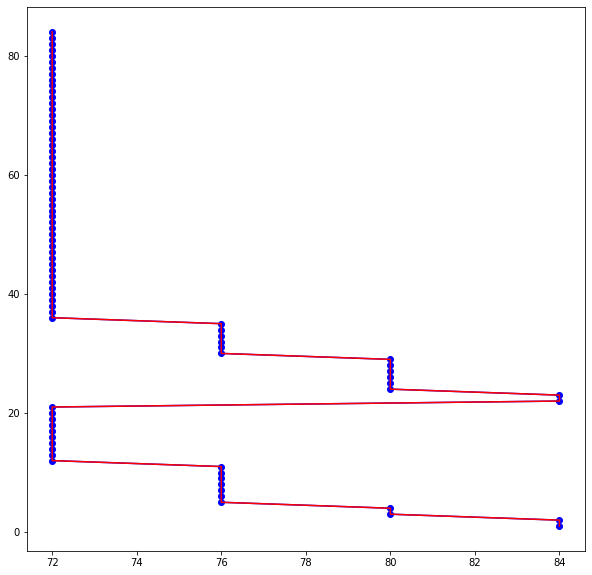

In [338]:
result, az = plt.subplots(figsize=(10,10))

y = [
    i
    for i in range(1, len(use_rate_pa)+1)
]

az.plot(use_rate_pa, y, marker='o', label='Pontos', color='blue')

az.plot(use_rate_pa, y, linestyle='-', color='red', label='Linha')


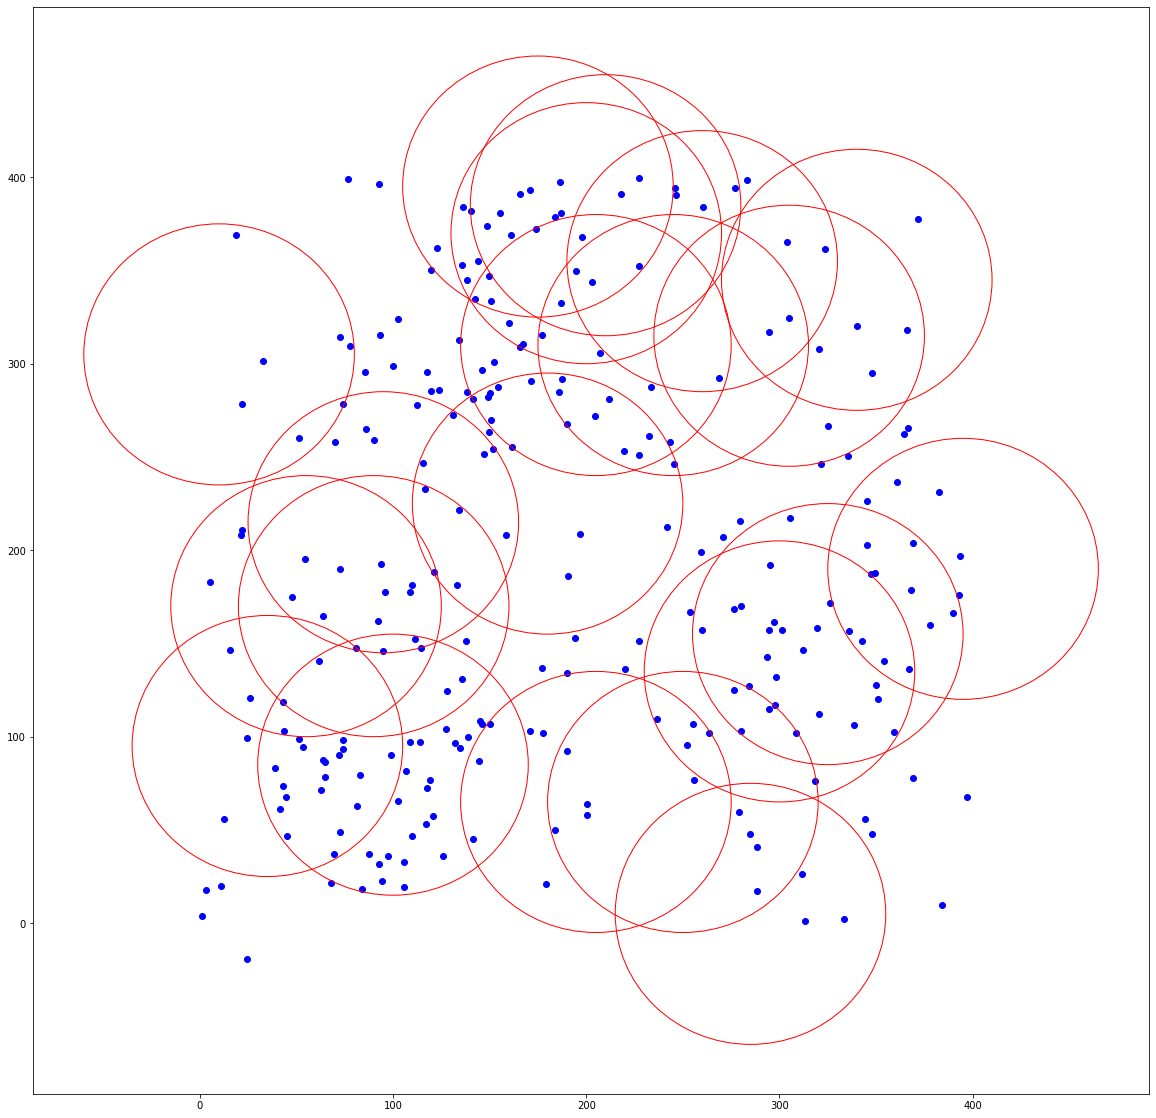

In [350]:
fig, ax = plt.subplots(figsize=(20,20))

ax.scatter(clients['x'], clients['y'], label='Users', color='blue', marker='o')

for index, row in pas.iterrows():
    if row['isActive']:
        ax.add_patch(plt.Circle((row['x'], row['y']), 70, fill=False, color="r"))

fig.savefig('plotcircles.png')

plt.show()